# Machine Learning for Cybersecurity - Part 1
### An example of ML-based botnet NIDS

In this lab we will build a state-of-the-art ML-based botnet NIDS. 

We will consider the scenario depicted below. The enterprise internal network is composed of many hosts, where one machine has been compromised by a botnet malware communicating with a Command and Control system (CnC). The network traffic is inspected by a NIDS that analyzes network flows to identify botnet activities by means of supervised machine learning model. 

In particular, you will be using an already labeled dataset from the [CTU-13](https://www.stratosphereips.org/datasets-ctu13) collection.

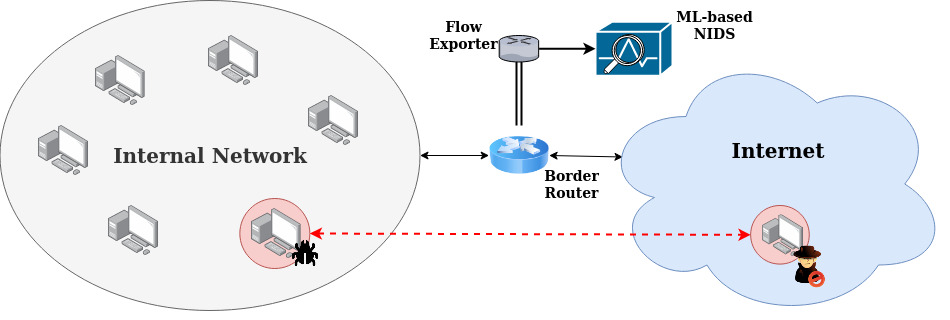
 

In [ ]:
!wget -q -P /content/ https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-42/detailed-bidirectional-flow-labels/capture20110810.binetflow

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

The downloaded .binetflow file is a csv that can be read with pandas.
The result will be stored in a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [ ]:
data = pd.read_csv("/content/capture20110810.binetflow")

## Data Preprocessing

**Every** ML project starts with a preprocessing stage in which the data you have is transformed into a suitable format to be submitted to the ML model.

Have a look at the data just to make you an idea of what you will deal with.

In [ ]:
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,flow=Background
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,flow=Background-UDP-Established


The DataFrame has 14 feature columns + 1 Label column:

*   StartTime: timestamp of the first packet of the netflow
*   Dur: Duration (in seconds) of the communication
*   Proto: Transport protocol of the communication
*   Src/Dst Addr: Source and Destination IP addresses
*   S/D Port: Source and Destination ports
*   Dir: Direction of the communication
*   State: State of the connection
*   s/dTos: Source and Destination Type of Service
*   TotPkts: Total packets transmitted during the communication
*   TotBytes: Total number of bytes exchanged (in both directions)
*   SrcBytes: Number of outgoing bytes (from Source to Destination)





In [ ]:
data.shape

(2824636, 15)

Dataset of almost 3 milion samples.

Have a better look to the protocols considered in the data.

In [ ]:
data.Proto.value_counts()

udp          2270083
tcp           507557
icmp           39694
rtp             2570
rtcp            2339
igmp            1803
arp              477
ipv6-icmp         58
ipx/spx           13
udt               10
ipv6              10
esp               10
pim                7
rarp               4
unas               1
Name: Proto, dtype: int64

To simplify let us consider only TCP traffic and drop the timestamp column:

In [ ]:
data = data.drop(columns=['StartTime'])
tcp = data[data.Proto == 'tcp']
display(tcp.shape)
display(tcp.dtypes)

(507557, 14)

Dur         float64
Proto        object
SrcAddr      object
Sport        object
Dir          object
DstAddr      object
Dport        object
State        object
sTos        float64
dTos        float64
TotPkts       int64
TotBytes      int64
SrcBytes      int64
Label        object
dtype: object

Before anything else, control if the dataset contains any Null values.


In [ ]:
tcp.isna().any()

Dur         False
Proto       False
SrcAddr     False
Sport        True
Dir         False
DstAddr     False
Dport        True
State       False
sTos         True
dTos         True
TotPkts     False
TotBytes    False
SrcBytes    False
Label       False
dtype: bool

You have different options to deal with Null values:
* fill the nulls with a standard value (e.g., 0)
* drop the rows with a null value

In [ ]:
tcp.sTos.fillna(0.0, inplace = True)
tcp.dTos.fillna(0.0, inplace = True)

tcp.isna().any()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Dur         False
Proto       False
SrcAddr     False
Sport        True
Dir         False
DstAddr     False
Dport        True
State       False
sTos        False
dTos        False
TotPkts     False
TotBytes    False
SrcBytes    False
Label       False
dtype: bool

In [ ]:
tcp = tcp.dropna(subset=['Sport', 'Dport'])

display(tcp.shape)
display(tcp.isna().any())

(506882, 14)

Dur         False
Proto       False
SrcAddr     False
Sport       False
Dir         False
DstAddr     False
Dport       False
State       False
sTos        False
dTos        False
TotPkts     False
TotBytes    False
SrcBytes    False
Label       False
dtype: bool

Now you have a dataset with no null values.

Let's move on with the preprocessing. 

In [ ]:
tcp.Label.value_counts()

flow=Background-TCP-Established                                            223542
flow=Background-Established-cmpgw-CVUT                                     107489
flow=Background-TCP-Attempt                                                104983
flow=To-Background-CVUT-Proxy                                               19480
flow=Background                                                              9136
                                                                            ...  
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-60                                 1
flow=From-Botnet-V42-TCP-Established-HTTP-Adobe-4                               1
flow=From-Botnet-V42-TCP-Established-HTTP-Binary-Download-Custom-Port-5         1
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-49                                 1
flow=From-Botnet-V42-TCP-HTTP-Not-Encrypted-Down-2                              1
Name: Label, Length: 102, dtype: int64

Detection is a binary problem in which you are trying to discriminate between legitimiate and malicious inputs. 
However, the dataset offers **102 different labels**. We need to transform this set of labels into:
* **1**: if the flow contains botnet traffic
* **0**: if the flow does not contain botnet traffic

If we look at the [documentation](https://mcfp.weebly.com/ctu-malware-capture-botnet-42.html) of the dataset, you will see that the IP address that is involved in the malicious operations is 147.32.84.165, and it is labeled with "Botnet" in the netflow files.

Thus, we can filter the labels and check whether they contain "Botnet" in the text.

In [ ]:
display(len(tcp[tcp.Label.str.contains('Botnet')]))

tcp.Label = np.where(tcp.Label.str.contains('Botnet'), 1, 0)

display(tcp.Label.value_counts())

11756

0    495126
1     11756
Name: Label, dtype: int64

In [ ]:
tcp.head()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
2,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,0
3,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,0
5,3086.547363,tcp,66.169.184.207,49372,<?>,147.32.84.229,13363,PA_PA,0.0,0.0,591,45931,26480,0
7,20.360268,tcp,147.32.3.93,443,<?>,147.32.84.59,51790,FPA_FRPA,0.0,0.0,133,81929,67597,0
9,1065.003052,tcp,94.208.78.74,50687,<?>,147.32.84.229,13363,FPA_RPA,0.0,0.0,156,14804,7699,0


As you may already know most of the ML algorithms cannot deal with categorical data. 
One possible way to transform categorical data to a suitable format for ML models is **one-hot encoding**.
One-hot encoding is an operation that transforms a single column with multiple categorical values to one binary column for each possible value. It is called one-hot because the values of the final set of columns will be 1 only in the column that corresponds to the original value in the row.

Let's see how it works with the Dir column.

In [ ]:
tcp.Dir.value_counts()

   ->    496635
  <?>      6176
   ?>      4066
  <?          5
Name: Dir, dtype: int64

Dir is a categorical column with 4 different values. We will apply one-hot encoding on it. To do so, we will use the pandas utility function [get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)

In [ ]:
pd.get_dummies(tcp.Dir)

,->,?>,<?,<?>
2,0,0,0,1
3,0,0,0,1
5,0,0,0,1
7,0,0,0,1
9,0,0,0,1
...,...,...,...,...
2824594,1,0,0,0
2824603,1,0,0,0
2824605,1,0,0,0
2824613,1,0,0,0


In [ ]:
tcp_dset = pd.get_dummies(tcp, columns = ['Dir'], prefix = '', prefix_sep = '')
tcp_dset.head()

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>
2,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,0,0,0,0,1
3,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,0,0,0,0,1
5,3086.547363,tcp,66.169.184.207,49372,147.32.84.229,13363,PA_PA,0.0,0.0,591,45931,26480,0,0,0,0,1
7,20.360268,tcp,147.32.3.93,443,147.32.84.59,51790,FPA_FRPA,0.0,0.0,133,81929,67597,0,0,0,0,1
9,1065.003052,tcp,94.208.78.74,50687,147.32.84.229,13363,FPA_RPA,0.0,0.0,156,14804,7699,0,0,0,0,1


State is another categorical feature that contains flags for both source and destination (separated by "_").

Let's separate each flag into a binary column:

In [ ]:
tcp_dset.loc[:, "State_Split"] = tcp_dset.State.str.split("_")
state_l = tcp_dset['State_Split'].to_list()
src_state = []
dst_state = []
for i in state_l:
  src_state.append(i[0])
  dst_state.append(i[1])

tcp_dset.loc[:, "SrcState"] = src_state
tcp_dset.loc[:, "DstState"] = dst_state

states = ["F", "S", "P", "A", "R", "C", "E"]

for s in states:
  tcp_dset["SrcState_" + s] = tcp_dset["SrcState"].apply(lambda x: 1 if s in x else 0)
  tcp_dset["DstState_" + s] = tcp_dset["DstState"].apply(lambda x: 1 if s in x else 0)

tcp_dset = tcp_dset.drop(columns=["State", "State_Split", "SrcState", "DstState"])
tcp_dset.head()

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E
2,0.000326,tcp,217.163.21.35,80,147.32.86.194,2063,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0
3,0.056966,tcp,83.3.77.74,32882,147.32.85.5,21857,0.0,0.0,3,180,120,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0
5,3086.547363,tcp,66.169.184.207,49372,147.32.84.229,13363,0.0,0.0,591,45931,26480,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0
7,20.360268,tcp,147.32.3.93,443,147.32.84.59,51790,0.0,0.0,133,81929,67597,0,0,0,0,1,1,1,0,0,1,1,1,1,0,1,0,0,0,0
9,1065.003052,tcp,94.208.78.74,50687,147.32.84.229,13363,0.0,0.0,156,14804,7699,0,0,0,0,1,1,0,0,0,1,1,1,1,0,1,0,0,0,0


In [ ]:
tcp_dset.Proto = 0
tcp_dset.head()

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E
2,0.000326,0,217.163.21.35,80,147.32.86.194,2063,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0
3,0.056966,0,83.3.77.74,32882,147.32.85.5,21857,0.0,0.0,3,180,120,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0
5,3086.547363,0,66.169.184.207,49372,147.32.84.229,13363,0.0,0.0,591,45931,26480,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0
7,20.360268,0,147.32.3.93,443,147.32.84.59,51790,0.0,0.0,133,81929,67597,0,0,0,0,1,1,1,0,0,1,1,1,1,0,1,0,0,0,0
9,1065.003052,0,94.208.78.74,50687,147.32.84.229,13363,0.0,0.0,156,14804,7699,0,0,0,0,1,1,0,0,0,1,1,1,1,0,1,0,0,0,0


Now we have a dataset suitable for the next phases. 

However, we still have not checked whether the numerical features contain outlier values that will affect the detection performance.

Let's have a look at the distribution of the numerical features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7190289550>,
      dtype=object)

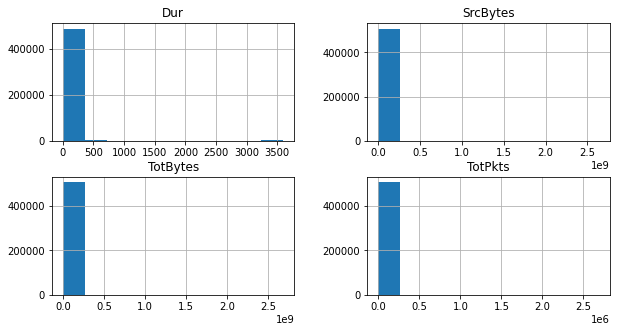

In [ ]:
tcp_dset[['Dur', 'SrcBytes', 'TotBytes', 'TotPkts']].hist(figsize=(10, 5))

We have outliers!!!

In [ ]:
for c in ['Dur', 'SrcBytes', 'TotBytes', 'TotPkts']:
  display(f"Feature {c}")
  display(tcp_dset[c].describe())

  print(f"95th Quantile {tcp_dset[c].quantile([0.95])}")

'Feature Dur'

count    506882.000000
mean         99.903999
std         462.590413
min           0.000000
25%           0.220716
50%           2.042125
75%          16.687634
max        3600.000000
Name: Dur, dtype: float64

95th Quantile 0.95    291.503842
Name: Dur, dtype: float64


'Feature SrcBytes'

count    5.068820e+05
mean     2.099831e+04
std      4.382658e+06
min      0.000000e+00
25%      1.860000e+02
50%      8.840000e+02
75%      1.685000e+03
max      2.635366e+09
Name: SrcBytes, dtype: float64

95th Quantile 0.95    8828.0
Name: SrcBytes, dtype: float64


'Feature TotBytes'

count    5.068820e+05
mean     1.001338e+05
std      7.511386e+06
min      6.000000e+01
25%      2.520000e+02
50%      1.893000e+03
75%      7.590000e+03
max      2.689640e+09
Name: TotBytes, dtype: float64

95th Quantile 0.95    66609.8
Name: TotBytes, dtype: float64


'Feature TotPkts'

count    5.068820e+05
mean     1.182248e+02
std      7.292416e+03
min      1.000000e+00
25%      4.000000e+00
50%      1.100000e+01
75%      2.300000e+01
max      2.686731e+06
Name: TotPkts, dtype: float64

95th Quantile 0.95    120.0
Name: TotPkts, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f719009e3d0>,
      dtype=object)

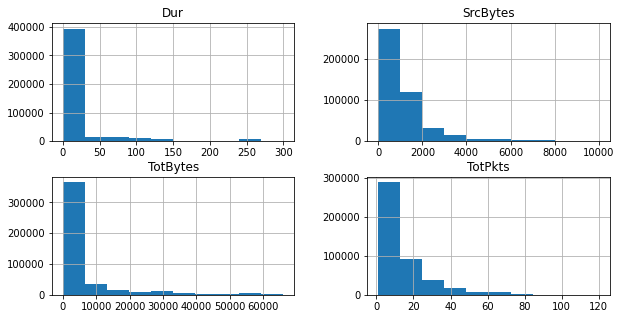

In [ ]:
initial_length = len(tcp_dset)

final_dset = tcp_dset[tcp_dset.Dur <= 300]
final_dset = final_dset[final_dset.SrcBytes <= 10000]
final_dset = final_dset[final_dset.TotBytes <= 66000]
final_dset = final_dset[final_dset.TotPkts <= 120]

final_dset[['Dur', 'SrcBytes', 'TotBytes', 'TotPkts']].hist(figsize=(10, 5))

In [ ]:
final_length = len(final_dset)
display(final_length)
display(initial_length - final_length)

456490

50392

IP Address transformation

In [ ]:
final_dset.SrcAddr.value_counts()

147.32.84.59     96469
70.37.98.60      64001
147.32.84.171    20380
147.32.86.20     13450
147.32.84.165    11381
                 ...  
114.41.33.204        1
83.149.3.164         1
95.89.79.183         1
41.84.152.6          1
85.26.184.179        1
Name: SrcAddr, Length: 15258, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le_addr_final_dset = final_dset.copy()

le_src_addr = LabelEncoder()
le_dst_addr = LabelEncoder()
le_addr_final_dset.loc[:, "SrcAddr"] = le_src_addr.fit_transform(le_addr_final_dset.loc[:, "SrcAddr"])
le_addr_final_dset.loc[:, "DstAddr"] = le_dst_addr.fit_transform(le_addr_final_dset.loc[:, "DstAddr"])

display(le_addr_final_dset.head())
display(le_addr_final_dset.SrcAddr.max())

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E
2,0.000326,0,6757,80,1612,2063,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0
3,0.056966,0,11571,32882,1451,21857,0.0,0.0,3,180,120,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0
11,0.187434,0,2071,2065,5989,80,0.0,0.0,11,3872,1147,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
13,0.000307,0,9502,80,1206,49382,0.0,0.0,3,180,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0
14,0.000258,0,9796,80,1612,2060,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0


15257

In [ ]:
le_addr_final_dset.dtypes

Dur           float64
Proto           int64
SrcAddr         int64
Sport          object
DstAddr         int64
Dport          object
sTos          float64
dTos          float64
TotPkts         int64
TotBytes        int64
SrcBytes        int64
Label           int64
   ->           uint8
   ?>           uint8
  <?            uint8
  <?>           uint8
SrcState_F      int64
DstState_F      int64
SrcState_S      int64
DstState_S      int64
SrcState_P      int64
DstState_P      int64
SrcState_A      int64
DstState_A      int64
SrcState_R      int64
DstState_R      int64
SrcState_C      int64
DstState_C      int64
SrcState_E      int64
DstState_E      int64
dtype: object

In [ ]:
le_addr_final_dset.Sport = le_addr_final_dset.Sport.astype(np.int64)
le_addr_final_dset.Dport = le_addr_final_dset.Dport.astype(np.int64)

In [ ]:
le_addr_final_dset.dtypes

Dur           float64
Proto           int64
SrcAddr         int64
Sport           int64
DstAddr         int64
Dport           int64
sTos          float64
dTos          float64
TotPkts         int64
TotBytes        int64
SrcBytes        int64
Label           int64
   ->           uint8
   ?>           uint8
  <?            uint8
  <?>           uint8
SrcState_F      int64
DstState_F      int64
SrcState_S      int64
DstState_S      int64
SrcState_P      int64
DstState_P      int64
SrcState_A      int64
DstState_A      int64
SrcState_R      int64
DstState_R      int64
SrcState_C      int64
DstState_C      int64
SrcState_E      int64
DstState_E      int64
dtype: object

We applied a few set of data transformation before model training. 
As we will use a 

In [ ]:
def print_ben_mal_ratio(dset):
  ben = dset[dset.Label == 0]
  mal = dset[dset.Label == 1]

  print(f'Number of benign: {len(ben)}')
  print(f'Number of malicious: {len(mal)}')

  print(f'Ratio Benign/Malicious: {len(ben) / len(mal)}')

print_ben_mal_ratio(le_addr_final_dset)

Number of benign: 445109
Number of malicious: 11381
Ratio Benign/Malicious: 39.10983217643441


The dataset is highly imbalanced. Previous work shows that a good ben:mal ratio is 20:1.

In [ ]:
def generate_tset_correct_ratio(mal, ben):
  training_set = pd.concat([mal, ben.sample(len(mal) * 20, random_state=42)]).sample(frac=1, random_state = 42)

  mal2 = training_set[training_set.Label == 1]
  ben2 = training_set[training_set.Label == 0]

  print(f'Ratio Benign/Malicious: {len(ben2) / len(mal2)}')
  return training_set

In [ ]:
ben = le_addr_final_dset[le_addr_final_dset.Label == 0]
mal = le_addr_final_dset[le_addr_final_dset.Label == 1]

training_set = generate_tset_correct_ratio(mal, ben)
training_set.head()

Ratio Benign/Malicious: 20.0


,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E
460905,0.081021,0,2014,49597,9743,80,0.0,0.0,10,2565,1132,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0
319200,0.612835,0,9304,61995,1253,51029,0.0,0.0,4,252,132,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
2539639,3.005296,0,945,52679,1580,12114,0.0,0.0,2,148,148,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
972506,0.049644,0,1988,61711,5565,80,0.0,0.0,9,960,397,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
2772852,25.250616,0,1988,37459,11158,80,0.0,0.0,12,1994,1350,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0


# Model training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_set.drop(columns=['Label']), training_set.Label, test_size = 0.25, random_state = 42, stratify = training_set.Label)

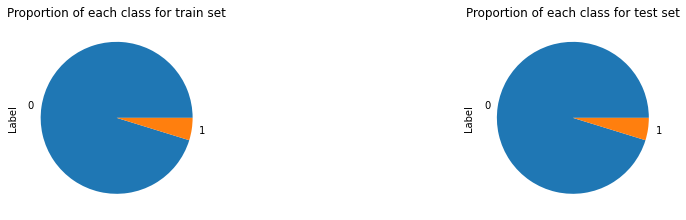

In [ ]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='Label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='Label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

In [ ]:
print(f'Training ratio: {len(y_train[y_train == 0]) / len(y_train[y_train==1])}')
print(f'Test ratio: {len(y_test[y_test == 0]) / len(y_test[y_test==1])}')

Training ratio: 19.99929709465792
Test ratio: 20.002108963093146


In [ ]:
model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=42)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
pred = model.predict(X_test)

In [ ]:
print(f"Accuracy Score: {accuracy_score(y_test, pred)}")
print(f"Recall Score: {recall_score(y_test, pred)}")
print(f"Precision Score: {precision_score(y_test, pred)}")
print(f"F1 Score: {f1_score(y_test, pred)}")

Accuracy Score: 0.9999832638784288
Recall Score: 0.9996485061511423
Precision Score: 1.0
F1 Score: 0.9998242221831604


In [ ]:
model.feature_importances_

array([4.88586855e-02, 0.00000000e+00, 2.72575548e-01, 1.09221930e-01,
       7.07849900e-02, 2.49381317e-01, 1.39482764e-07, 1.52706280e-07,
       3.45821112e-02, 6.84435883e-02, 5.53967874e-02, 5.50174678e-04,
       1.99697075e-04, 0.00000000e+00, 5.85989520e-05, 2.81135249e-03,
       4.85922919e-03, 7.52442410e-04, 1.25040016e-02, 9.61224722e-04,
       5.02038946e-03, 1.95877638e-02, 3.74130513e-02, 1.46306063e-03,
       4.57350541e-03, 2.58389755e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [ ]:
importances = model.feature_importances_.tolist()
imp_d = {}

for c, v in zip(X_train.columns, importances):
  imp_d[c] = v

imp_d = sorted(imp_d.items(), key=lambda x:-x[1])
imp_d

[('SrcAddr', 0.2725755480088433),
 ('Dport', 0.24938131707905883),
 ('Sport', 0.10922193017592724),
 ('DstAddr', 0.07078499003420054),
 ('TotBytes', 0.06844358830894337),
 ('SrcBytes', 0.0553967873961428),
 ('Dur', 0.04885868550211749),
 ('DstState_A', 0.037413051321982076),
 ('TotPkts', 0.034582111162886175),
 ('SrcState_A', 0.019587763829897416),
 ('DstState_S', 0.012504001582025375),
 ('DstState_P', 0.005020389463369133),
 ('DstState_F', 0.004859229194740477),
 ('DstState_R', 0.004573505411481254),
 ('SrcState_F', 0.002811352486786537),
 ('SrcState_R', 0.0014630606255589306),
 ('SrcState_P', 0.0009612247218438475),
 ('SrcState_S', 0.0007524424103932633),
 ('   ->', 0.0005501746777351979),
 ('   ?>', 0.0001996970752480323),
 ('  <?>', 5.8598952019789e-05),
 ('SrcState_C', 2.5838975503088005e-07),
 ('dTos', 1.5270628038330967e-07),
 ('sTos', 1.3948276358089386e-07),
 ('Proto', 0.0),
 ('  <?', 0.0),
 ('DstState_C', 0.0),
 ('SrcState_E', 0.0),
 ('DstState_E', 0.0)]

In [ ]:
print(f"Src Label: {le_src_addr.transform(['147.32.84.165'])}")
print(f"Dst Label: {le_dst_addr.transform(['147.32.84.165'])}")

Src Label: [1961]
Dst Label: [1069]


In [ ]:
mal

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E
675877,0.045125,0,1961,1027,8786,80,0.0,0.0,7,882,629,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0
691742,0.216252,0,1961,1040,12462,80,0.0,0.0,37,27990,1046,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
692043,2.568064,0,1961,1041,6815,2012,0.0,0.0,72,60278,1897,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
692222,13.535808,0,1961,1042,3952,80,0.0,0.0,70,41849,1962,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
692557,0.758234,0,1961,1044,6815,888,0.0,0.0,9,2589,611,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784744,3.004279,0,1961,1389,4062,25,0.0,0.0,2,124,124,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2784969,3.004314,0,1961,1305,3120,25,0.0,0.0,2,124,124,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2784970,3.004330,0,1961,1232,7168,25,0.0,0.0,2,124,124,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2785059,3.003875,0,1961,1401,4710,25,0.0,0.0,2,124,124,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mod_mal = mal.copy()
#mod_mal.SrcAddr = 1962
mod_mal.SrcAddr = 3500
#mod_mal.Sport = mod_mal.Sport + 100
#mod_mal.Dport = mod_mal.Dport + 100

mod_mal_test = mod_mal.loc[y_test[y_test==1].index]

In [ ]:
mod_mal_test

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E
1010443,9.027827,0,3500,3129,5189,25,0.0,0.0,3,186,186,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2252989,36.152111,0,3500,3493,5253,4506,0.0,0.0,6,372,372,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1682601,8.989665,0,3500,1500,7641,25,0.0,0.0,3,186,186,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1225423,9.014253,0,3500,4490,4599,25,0.0,0.0,3,186,186,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
768918,3.004485,0,3500,1514,304,6667,0.0,0.0,2,124,124,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042601,8.828845,0,3500,3314,5846,25,0.0,0.0,3,186,186,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2190100,9.013421,0,3500,4101,5129,25,0.0,0.0,3,186,186,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
810565,9.011941,0,3500,1765,5189,25,0.0,0.0,3,186,186,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1308562,9.012551,0,3500,4752,11308,25,0.0,0.0,3,186,186,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mod_pred = model.predict(mod_mal_test.drop(columns = ['Label']))

In [ ]:
print(f"Recall Score: {recall_score(mod_mal_test.Label, mod_pred)}")

Recall Score: 0.0


Can you see what happened?

In [ ]:
final_dset.head()

,Dur,Proto,SrcAddr,Sport,DstAddr,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E
2,0.000326,0,217.163.21.35,80,147.32.86.194,2063,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0
3,0.056966,0,83.3.77.74,32882,147.32.85.5,21857,0.0,0.0,3,180,120,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0
11,0.187434,0,147.32.86.194,2065,217.163.21.35,80,0.0,0.0,11,3872,1147,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
13,0.000307,0,74.200.246.228,80,147.32.84.59,49382,0.0,0.0,3,180,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0
14,0.000258,0,77.238.167.32,80,147.32.86.194,2060,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0


In [ ]:
binary_addr_final_dset = final_dset.copy()

binary_addr_final_dset['IPSrcType'] = np.where(final_dset.SrcAddr.str.startswith("147.32."), 1, 0)
binary_addr_final_dset['IPDstType'] = np.where(final_dset.DstAddr.str.startswith("147.32."), 1, 0)

binary_addr_final_dset = binary_addr_final_dset.drop(columns=['SrcAddr', 'DstAddr'])

binary_addr_final_dset.head()

,Dur,Proto,Sport,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E,IPSrcType,IPDstType
2,0.000326,0,80,2063,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
3,0.056966,0,32882,21857,0.0,0.0,3,180,120,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1
11,0.187434,0,2065,80,0.0,0.0,11,3872,1147,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0
13,0.000307,0,80,49382,0.0,0.0,3,180,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1
14,0.000258,0,80,2060,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1


In [ ]:
binary_addr_final_dset.Sport = binary_addr_final_dset.Sport.astype(np.int64)
binary_addr_final_dset.Dport = binary_addr_final_dset.Dport.astype(np.int64)

In [ ]:
binary_addr_final_dset['SrcPort'] = np.where(binary_addr_final_dset.Sport.between(0, 1023, inclusive=True),
                                             "SrcPort_Well_Known",
                                             np.where(binary_addr_final_dset.Sport.between(1024, 49151, inclusive = True), 
                                                      "SrcPort_Registered", "SrcPort_Private")
                                             )

binary_addr_final_dset['DstPort'] = np.where(binary_addr_final_dset.Dport.between(0, 1023, inclusive=True),
                                             "DstPort_Well_Known",
                                             np.where(binary_addr_final_dset.Dport.between(1024, 49151, inclusive = True), 
                                                      "DstPort_Registered", "DstPort_Private")
                                             )

In [ ]:
binary_addr_final_dset.head()

,Dur,Proto,Sport,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E,IPSrcType,IPDstType,SrcPort,DstPort
2,0.000326,0,80,2063,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,SrcPort_Well_Known,DstPort_Registered
3,0.056966,0,32882,21857,0.0,0.0,3,180,120,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,SrcPort_Registered,DstPort_Registered
11,0.187434,0,2065,80,0.0,0.0,11,3872,1147,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,SrcPort_Registered,DstPort_Well_Known
13,0.000307,0,80,49382,0.0,0.0,3,180,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,SrcPort_Well_Known,DstPort_Private
14,0.000258,0,80,2060,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,SrcPort_Well_Known,DstPort_Registered


In [ ]:
binary_addr_final_dset = pd.get_dummies(binary_addr_final_dset, columns = ['SrcPort', 'DstPort'],
                                        prefix="", prefix_sep="")

binary_addr_final_dset = binary_addr_final_dset.drop(columns = ["Sport", "Dport"])

binary_addr_final_dset.head()

,Dur,Proto,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E,IPSrcType,IPDstType,SrcPort_Private,SrcPort_Registered,SrcPort_Well_Known,DstPort_Private,DstPort_Registered,DstPort_Well_Known
2,0.000326,0,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,0.056966,0,0.0,0.0,3,180,120,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0
11,0.187434,0,0.0,0.0,11,3872,1147,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1
13,0.000307,0,0.0,0.0,3,180,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0
14,0.000258,0,0.0,0.0,2,120,60,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0


In [ ]:
ben2 = binary_addr_final_dset[binary_addr_final_dset.Label == 0]
mal2 = binary_addr_final_dset[binary_addr_final_dset.Label == 1]

training_set_2 = generate_tset_correct_ratio(mal2, ben2)
training_set_2.head()

Ratio Benign/Malicious: 20.0


,Dur,Proto,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,->,?>,<?,<?>,SrcState_F,DstState_F,SrcState_S,DstState_S,SrcState_P,DstState_P,SrcState_A,DstState_A,SrcState_R,DstState_R,SrcState_C,DstState_C,SrcState_E,DstState_E,IPSrcType,IPDstType,SrcPort_Private,SrcPort_Registered,SrcPort_Well_Known,DstPort_Private,DstPort_Registered,DstPort_Well_Known
460905,0.081021,0,0.0,0.0,10,2565,1132,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1
319200,0.612835,0,0.0,0.0,4,252,132,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0
2539639,3.005296,0,0.0,0.0,2,148,148,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
972506,0.049644,0,0.0,0.0,9,960,397,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1
2772852,25.250616,0,0.0,0.0,12,1994,1350,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_set_2.drop(columns=['Label']), 
                                                    training_set_2.Label, test_size = 0.25, 
                                                    random_state = 42, stratify = training_set_2.Label)

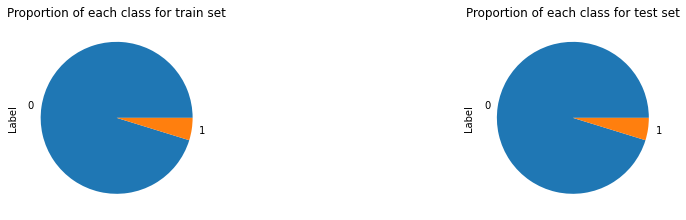

In [ ]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='Label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='Label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

In [ ]:
model2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=42)

In [ ]:
model2.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
pred = model2.predict(X_test)

In [ ]:
print(f"Accuracy Score: {accuracy_score(y_test, pred)}")
print(f"Recall Score: {recall_score(y_test, pred)}")
print(f"Precision Score: {precision_score(y_test, pred)}")
print(f"F1 Score: {f1_score(y_test, pred)}")

Accuracy Score: 0.994811802312932
Recall Score: 0.9377855887521969
Precision Score: 0.9525169582292039
F1 Score: 0.945093871767623


In [ ]:
importances = model2.feature_importances_.tolist()
imp_d = {}

for c, v in zip(X_train.columns, importances):
  imp_d[c] = v

imp_d = sorted(imp_d.items(), key=lambda x:-x[1])
imp_d

[('Dur', 0.22676454768091592),
 ('DstPort_Well_Known', 0.1447227773792655),
 ('TotBytes', 0.13633579869226153),
 ('SrcBytes', 0.10822346859972103),
 ('IPDstType', 0.06295668289007995),
 ('TotPkts', 0.061753678020042786),
 ('DstPort_Registered', 0.04903439599513371),
 ('IPSrcType', 0.041225983899110655),
 ('DstState_A', 0.037763822282481735),
 ('SrcPort_Registered', 0.031482781701094614),
 ('SrcPort_Private', 0.023481119301813687),
 ('DstState_S', 0.015738314671699356),
 ('DstPort_Private', 0.01376412267949874),
 ('SrcState_A', 0.011529060940149844),
 ('DstState_F', 0.010888098641720034),
 ('DstState_R', 0.005936469837313133),
 ('SrcState_P', 0.005316919519538344),
 ('DstState_P', 0.0035010012149055696),
 ('SrcState_R', 0.0033236713190271995),
 ('SrcState_F', 0.0029272443146647685),
 ('SrcState_S', 0.0013240687068227163),
 ('   ?>', 0.000933424350768341),
 ('   ->', 0.0006762165836153652),
 ('SrcPort_Well_Known', 0.0002905113748303574),
 ('  <?>', 8.42626035067905e-05),
 ('dTos', 1.8545